# Code for competition

Libraries imports and initializations

In [1]:
import tensorflow as tf
import numpy as np
import os, os.path
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau
#import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(f"Tensorflow version = ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Tensorflow version =  2.10.0
Num GPUs Available:  1


Load the dataset

In [2]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]

# for each species
for i in range(0, len(images_ind)):
    # for each image in every species folder
    for j in range(0, images_ind[i]):
        temp = Image.open(f'training_data_final/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

# creation of augmented dataset 
X = np.array(samples)
y = np.array(targets, dtype=np.uint8)
print(X.shape, y.shape)
print(X.dtype, y.dtype, sep=", ")

(3542, 96, 96, 3) (3542, 8)
uint8, uint8


Models metadata

In [3]:
input_shape = X.shape[1:]
image_shape = input_shape[:-1]

batch_size = 128 # TODO: try with other batch sizes and check the difference in accuracy and GPU utilization
epochs = 400
labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Static augmentation

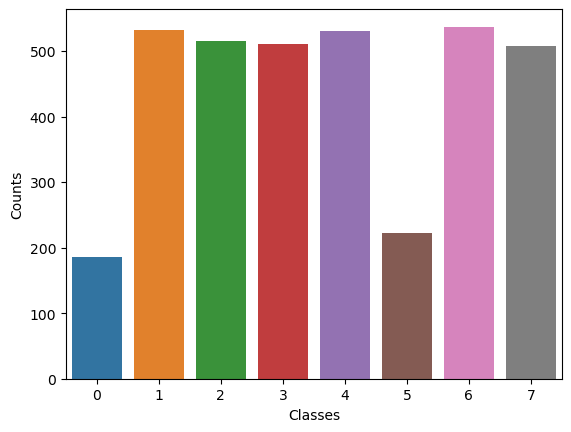

In [4]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

#shows classes imbalance
plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()


Split the dataset (85-15) before augmentation

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.15)
y_numeric = []
for v in y:
    y_numeric.append(np.argmax(v))
'''class_weights_vect = class_weight.compute_class_weight('balanced', classes=classes, y=y_numeric)'''
'''class_weights = dict(enumerate(class_weights_vect))'''
class_weights_vect = [3.,1.,1.,1.,1.,3.,1.,3.]
class_weights = dict(enumerate(class_weights_vect))
print(class_weights)
print(f"training set input shape", X_train.shape, y_train.shape)
print(f"validation set input shape", X_val.shape, y_val.shape)
print(y_train[0])

{0: 3.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 3.0, 6: 1.0, 7: 3.0}
training set input shape (3010, 96, 96, 3) (3010, 8)
validation set input shape (532, 96, 96, 3) (532, 8)
[0 0 0 0 1 0 0 0]


In [6]:
# image transformations generator for the training set ONLY
gen = ImageDataGenerator(rotation_range = 90,
                         height_shift_range = 30,
                         width_shift_range = 30,
                         horizontal_flip = True,
                         zoom_range=[0.7,1.5], # added zoom range
                         fill_mode = 'reflect'
                         )

#compute number of images to reach for each category in the training set
required_expansion = 600

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(classes)):
    ref_list.append([])
  
for i in range(0, len(y_train)):
    ref_list[np.argmax(y_train[i])].append(X_train[i])

for i in range(0, len(classes)):
    length = len(ref_list[i])
    to_produce = int(class_weights_vect[i] * required_expansion) 
    target = tfk.utils.to_categorical(i, len(classes))
    print(f'Computing {to_produce} augmented images for target {i}')

    # produces images and corresponding targets
    aug_targets_i = np.full((length, len(classes)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)

    # augmented data samples
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

# augmented dataset
X_aug_train = np.concatenate((X_train, np.array(aug_samples)))
y_aug_train = np.concatenate((y_train, np.array(aug_targets)))

print(X_aug_train.shape, y_aug_train.shape)
print(X_aug_train.dtype, y_aug_train.dtype, sep=", ")
print(y_aug_train[0])
#adjusting both saturation and constrast of both training and validation
temp = []
for img in X_aug_train: 
    temp.append(np.array(tf.image.adjust_contrast(tf.image.adjust_saturation(img, 1.2), 1.01)))
X_aug_train = np.array(temp)
temp = []
for img in X_val: 
    temp.append(np.array(tf.image.adjust_contrast(tf.image.adjust_saturation(img, 1.2), 1.01)))
X_val = np.array(temp)



Computing 1800 augmented images for target 0
Computing 600 augmented images for target 1
Computing 600 augmented images for target 2
Computing 600 augmented images for target 3
Computing 600 augmented images for target 4
Computing 1800 augmented images for target 5
Computing 600 augmented images for target 6
Computing 1800 augmented images for target 7
(11410, 96, 96, 3) (11410, 8)
float32, float32
[0. 0. 0. 0. 1. 0. 0. 0.]


Showing a few examples of augmented images, one image per class

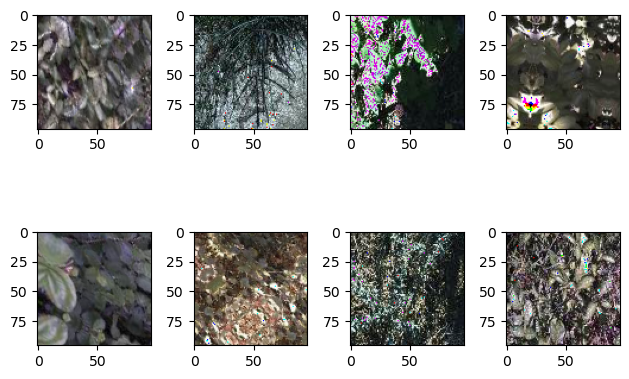

In [7]:
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
for i in range(num_row * num_col):

    # show a random augmented image -> not working 
    img = random.choice(X_aug_train)
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.fromarray(img.astype(np.uint8)))
    #ax.set_title(labels[i])

plt.tight_layout()
plt.show()

Dataset balanced and shuffled

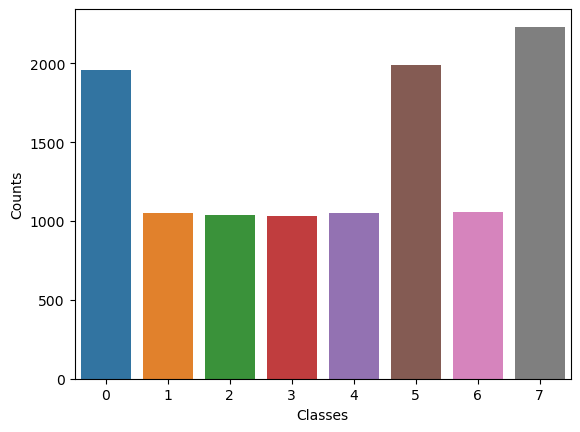

In [8]:
# counts of the number of samples per each class after the rebalance
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_aug_train], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

# probably not needed, wrote this just in case
X_aug_train, y_aug_train = shuffle(X_aug_train, y_aug_train)

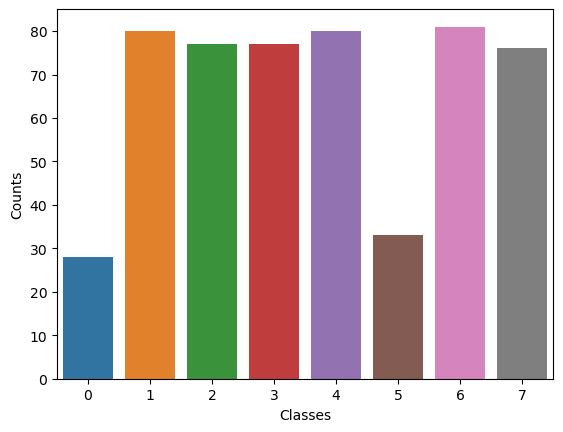

In [9]:
# Plot y_val histogram
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_val], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Models definition

Convolutional model defined as a stack of some convolution layers, max pooling, gap and dropout layers.

Fully connected dense layers stacked after the convolutional layers, with no regularization applied. 5 layers of 128 neurons each

In [10]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'conv_dense_model_v1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model
    


# First attempt: Hold Out validation

Train the model

In [11]:
# first convolutional model
model = build_model(input_shape)

# Use the supernet only as feature extractor (eventually apply fine tuning)
model.get_layer('xception').trainable = True
for i, layer in enumerate(model.get_layer('xception').layers[:-10]):
  layer.trainable=True
  
model.summary()
#visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

Model: "conv_dense_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 output_layer (Dense)        (None, 8)                 16392     
                                                                 
Total params: 20,877,872
Trainable params: 20,823,344
Non-trainable params: 54,528
_________________________________________________________________


In [12]:
from tensorflow.keras.applications.xception import preprocess_input
X_train_tl = preprocess_input(X_aug_train)
X_val_tl = preprocess_input(X_val)

# training
history = model.fit(
    x = X_train_tl,
    y = y_aug_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_tl, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True)]
).history

Epoch 1/400
90/90 [==============================] - 38s 362ms/step - loss: 1.4236 - accuracy: 0.4839 - val_loss: 1.3278 - val_accuracy: 0.5432
Epoch 2/400
90/90 [==============================] - 31s 350ms/step - loss: 0.5352 - accuracy: 0.8280 - val_loss: 0.8774 - val_accuracy: 0.6635
Epoch 3/400
90/90 [==============================] - 31s 349ms/step - loss: 0.1822 - accuracy: 0.9562 - val_loss: 0.7410 - val_accuracy: 0.7500
Epoch 4/400
90/90 [==============================] - 31s 345ms/step - loss: 0.0617 - accuracy: 0.9904 - val_loss: 0.7517 - val_accuracy: 0.7632
Epoch 5/400
90/90 [==============================] - 31s 347ms/step - loss: 0.0273 - accuracy: 0.9961 - val_loss: 0.7626 - val_accuracy: 0.7782
Epoch 6/400
90/90 [==============================] - 31s 345ms/step - loss: 0.0161 - accuracy: 0.9979 - val_loss: 0.7887 - val_accuracy: 0.7744
Epoch 7/400
90/90 [==============================] - 31s 345ms/step - loss: 0.0121 - accuracy: 0.9988 - val_loss: 0.7708 - val_accuracy:

### Plot training results

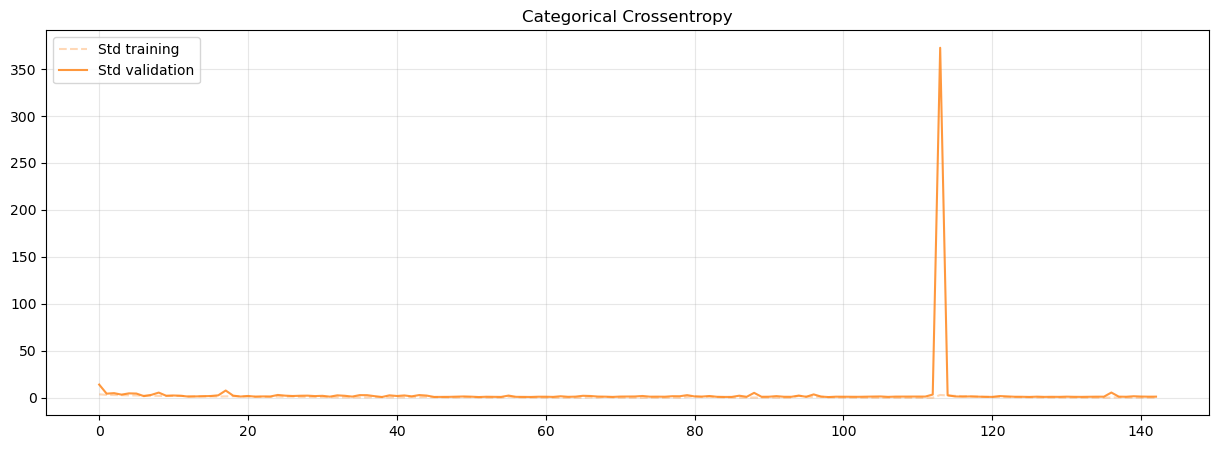

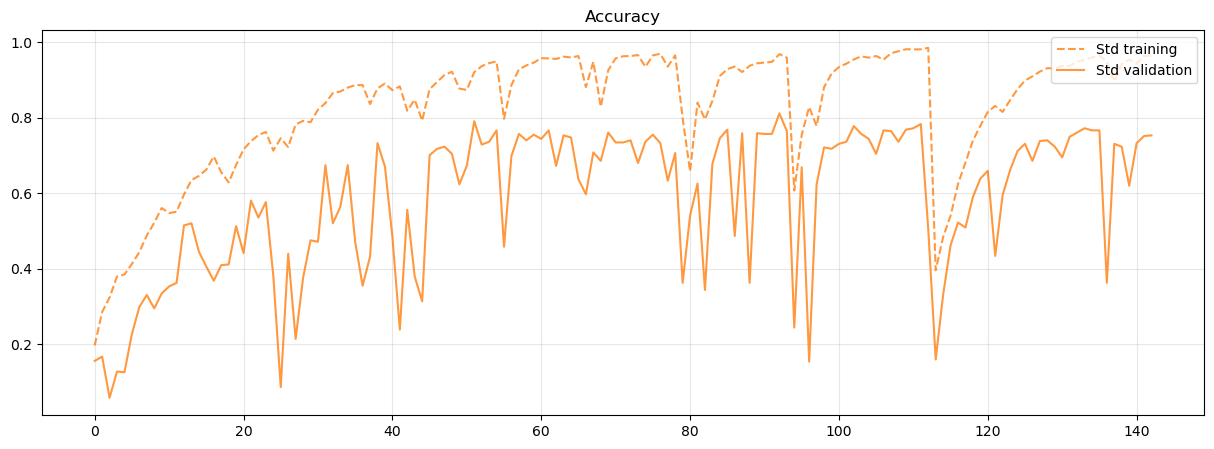

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


Plot the confusion matrix (evaluated on the validation set)

17/17 [==============================] - 1s 21ms/step
[0.39130435 0.82485876 0.8255814  0.76433121 0.88607595 0.82857143
 0.89932886 0.78518519]
Accuracy: 0.812
Precision: 0.7893
Recall: 0.7767
F1: 0.7757


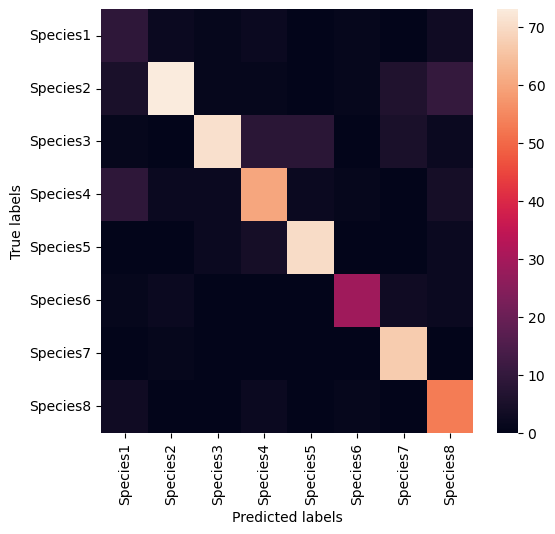

In [ ]:
predictions = model.predict(X_val_tl)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print(f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None))
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(6,5.5))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

Plot one example of an image for each class from the validation set of images.
For each image show the prediction on a bar plot

In [ ]:
#TODO: fix this code
example_prediction = random.choice(X_val[0])
'''
fig, axes = plt.subplots(8,2)
fig.set_size_inches(10,20)
for i in range(8):

	# TODO: find random choice from validation set, one per class

	axes[i, 0].imshow(X_val[choice])
	axes[i, 0].set_title('True label: ' + labels[np.argmax(y_val[choice])])
	axes[i, 1].barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
	axes[i, 1].set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
	axes[i, 1].grid(alpha=.3)


plt.show()
'''

"\nfig, axes = plt.subplots(8,2)\nfig.set_size_inches(10,20)\nfor i in range(8):\n\n\t# TODO: find random choice from validation set, one per class\n\n\taxes[i, 0].imshow(X_val[choice])\n\taxes[i, 0].set_title('True label: ' + labels[np.argmax(y_val[choice])])\n\taxes[i, 1].barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)\n\taxes[i, 1].set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])\n\taxes[i, 1].grid(alpha=.3)\n\n\nplt.show()\n"

### Save supernet weights
Here it is not working

In [ ]:
model.save_weights('supernet_weights.h5')

17/17 - 0s - loss: 0.8951 - accuracy: 0.7857 - 414ms/epoch - 24ms/step
17/17 - 0s - loss: 1.1340 - accuracy: 0.8120 - 387ms/epoch - 23ms/step
Model improved!


INFO:tensorflow:Assets written to: gab_model_tl_new\assets


INFO:tensorflow:Assets written to: gab_model_tl_new\assets


In [ ]:
def build_final_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.Xception(include_top=False,
                                            weights=model.load_weights('supernet_weights.h5'),
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.Flatten()(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x)
    
    x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'conv_dense_model_v1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model
    

In [ ]:

final_model = build_final_model(input_shape)

# Use the supernet as a pretrained feature extraction net
model.get_layer('xception').trainable = False
for i, layer in enumerate(model.get_layer('xception').layers[:-10]):
  layer.trainable=False
  
model.summary()
#visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input
X_train_tl = preprocess_input(X_aug_train)
X_val_tl = preprocess_input(X_val)

# training
history = model.fit(
    x = X_train_tl,
    y = y_aug_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_tl, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True)]
).history

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


In [ ]:
predictions = model.predict(X_val_tl)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print(f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None))
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(6,5.5))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()